# Overview

In this notebook, we walk through all the necessary components of running experiments on LIBERO, and some common usage such as defining your own algorithm and policy architectures in the codebase.

1. Dataset preparation for your algorithms
2. Write your own algorithm
    - Subclassing from `Sequential` base class
3. Write your own model
4. Write your training loop
5. Visualize results

## 1. Experiments

In [ ]:
from hydra import compose, initialize

from libero.libero import benchmark, get_libero_path
import hydra
import pprint
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['PYOPENGL_PLATFORM'] = 'egl'
from omegaconf import OmegaConf
import yaml
from easydict import EasyDict
from libero.libero.benchmark import get_benchmark
from libero.lifelong.datasets import (GroupedTaskDataset, SequenceVLDataset, get_dataset)
from libero.lifelong.utils import (get_task_embs, safe_device, create_experiment_dir)
hydra.core.global_hydra.GlobalHydra.instance().clear()

### load the default hydra config
initialize(config_path="../libero/configs")
hydra_cfg = compose(config_name="config")
yaml_config = OmegaConf.to_yaml(hydra_cfg)
cfg = EasyDict(yaml.safe_load(yaml_config))

pp = pprint.PrettyPrinter(indent=2)
pp.pprint(cfg.policy)

# prepare lifelong learning
cfg.folder = get_libero_path("datasets")
cfg.bddl_folder = get_libero_path("bddl_files")
cfg.init_states_folder = get_libero_path("init_states")
cfg.eval.num_procs = 1
cfg.eval.n_eval = 5

cfg.train.n_epochs = 25

pp.pprint(f"Note that the number of epochs used in this example is intentionally reduced to 5.")

task_order = cfg.data.task_order_index # can be from {0 .. 21}, default to 0, which is [task 0, 1, 2 ...]
cfg.benchmark_name = "libero_object" # can be from {"libero_spatial", "libero_object", "libero_goal", "libero_10"}
benchmark = get_benchmark(cfg.benchmark_name)(task_order)

# prepare datasets from the benchmark
datasets = []
descriptions = []
shape_meta = None
n_tasks = benchmark.n_tasks

for i in range(n_tasks):
    # currently we assume tasks from same benchmark have the same shape_meta
    task_i_dataset, shape_meta = get_dataset(
            dataset_path=os.path.join(cfg.folder, benchmark.get_task_demonstration(i)),
            obs_modality=cfg.data.obs.modality,
            initialize_obs_utils=(i==0),
            seq_len=cfg.data.seq_len,
    )
    # add language to the vision dataset, hence we call vl_dataset
    descriptions.append(benchmark.get_task(i).language)
    datasets.append(task_i_dataset)

task_embs = get_task_embs(cfg, descriptions)
benchmark.set_task_embs(task_embs)

datasets = [SequenceVLDataset(ds, emb) for (ds, emb) in zip(datasets, task_embs)]
n_demos = [data.n_demos for data in datasets]
n_sequences = [data.total_num_sequences for data in datasets]

## 2. Write your own policy architecture

In [ ]:
import robomimic.utils.tensor_utils as TensorUtils
import torch
import torch.nn as nn

from einops import rearrange, repeat
from libero.lifelong.models.modules.rgb_modules import *
from libero.lifelong.models.modules.language_modules import *
from libero.lifelong.models.base_policy import BasePolicy
from libero.lifelong.models.policy_head import *
from libero.lifelong.models.modules.transformer_modules import *

###############################################################################
#
# A model handling extra input modalities besides images at time t.
#
###############################################################################

class ExtraModalityTokens(nn.Module):
    def __init__(
        self,
        use_joint=False,
        use_gripper=False,
        use_ee=False,
        extra_num_layers=0,
        extra_hidden_size=64,
        extra_embedding_size=32,
    ):
        """
        This is a class that maps all extra modality inputs into tokens of the same size
        """
        super().__init__()
        self.use_joint = use_joint
        self.use_gripper = use_gripper
        self.use_ee = use_ee
        self.extra_embedding_size = extra_embedding_size

        joint_states_dim = 7
        gripper_states_dim = 2
        ee_dim = 3

        self.num_extra = int(use_joint) + int(use_gripper) + int(use_ee)

        extra_low_level_feature_dim = (
            int(use_joint) * joint_states_dim
            + int(use_gripper) * gripper_states_dim
            + int(use_ee) * ee_dim
        )

        assert extra_low_level_feature_dim > 0, "[error] no extra information"

        self.extra_encoders = {}

        def generate_proprio_mlp_fn(modality_name, extra_low_level_feature_dim):
            assert extra_low_level_feature_dim > 0  # we indeed have extra information
            if extra_num_layers > 0:
                layers = [nn.Linear(extra_low_level_feature_dim, extra_hidden_size)]
                for i in range(1, extra_num_layers):
                    layers += [
                        nn.Linear(extra_hidden_size, extra_hidden_size),
                        nn.ReLU(inplace=True),
                    ]
                layers += [nn.Linear(extra_hidden_size, extra_embedding_size)]
            else:
                layers = [nn.Linear(extra_low_level_feature_dim, extra_embedding_size)]

            self.proprio_mlp = nn.Sequential(*layers)
            self.extra_encoders[modality_name] = {"encoder": self.proprio_mlp}

        for (proprio_dim, use_modality, modality_name) in [
            (joint_states_dim, self.use_joint, "joint_states"),
            (gripper_states_dim, self.use_gripper, "gripper_states"),
            (ee_dim, self.use_ee, "ee_states"),
        ]:

            if use_modality:
                generate_proprio_mlp_fn(modality_name, proprio_dim)

        self.encoders = nn.ModuleList(
            [x["encoder"] for x in self.extra_encoders.values()]
        )

    def forward(self, obs_dict):
        """
        obs_dict: {
            (optional) joint_stats: (B, T, 7),
            (optional) gripper_states: (B, T, 2),
            (optional) ee: (B, T, 3)
        }
        map above to a latent vector of shape (B, T, H)
        """
        tensor_list = []

        for (use_modality, modality_name) in [
            (self.use_joint, "joint_states"),
            (self.use_gripper, "gripper_states"),
            (self.use_ee, "ee_states"),
        ]:

            if use_modality:
                tensor_list.append(
                    self.extra_encoders[modality_name]["encoder"](
                        obs_dict[modality_name]
                    )
                )

        x = torch.stack(tensor_list, dim=-2)
        return x

###############################################################################
#
# A Transformer policy
#
###############################################################################


class MyTransformerPolicy(BasePolicy):
    """
    Input: (o_{t-H}, ... , o_t)
    Output: a_t or distribution of a_t
    """

    def __init__(self, cfg, shape_meta):
        super().__init__(cfg, shape_meta)
        policy_cfg = cfg.policy

        ### 1. encode image
        embed_size = policy_cfg.embed_size
        transformer_input_sizes = []
        self.image_encoders = {}
        for name in shape_meta["all_shapes"].keys():
            if "rgb" in name or "depth" in name:
                kwargs = policy_cfg.image_encoder.network_kwargs
                kwargs.input_shape = shape_meta["all_shapes"][name]
                kwargs.output_size = embed_size
                kwargs.language_dim = (
                    policy_cfg.language_encoder.network_kwargs.input_size
                )
                self.image_encoders[name] = {
                    "input_shape": shape_meta["all_shapes"][name],
                    "encoder": eval(policy_cfg.image_encoder.network)(**kwargs),
                }

        self.encoders = nn.ModuleList(
            [x["encoder"] for x in self.image_encoders.values()]
        )

        ### 2. encode language
        policy_cfg.language_encoder.network_kwargs.output_size = embed_size
        self.language_encoder = eval(policy_cfg.language_encoder.network)(
            **policy_cfg.language_encoder.network_kwargs
        )

        ### 3. encode extra information (e.g. gripper, joint_state)
        self.extra_encoder = ExtraModalityTokens(
            use_joint=cfg.data.use_joint,
            use_gripper=cfg.data.use_gripper,
            use_ee=cfg.data.use_ee,
            extra_num_layers=policy_cfg.extra_num_layers,
            extra_hidden_size=policy_cfg.extra_hidden_size,
            extra_embedding_size=embed_size,
        )

        ### 4. define temporal transformer
        policy_cfg.temporal_position_encoding.network_kwargs.input_size = embed_size
        self.temporal_position_encoding_fn = eval(
            policy_cfg.temporal_position_encoding.network
        )(**policy_cfg.temporal_position_encoding.network_kwargs)

        self.temporal_transformer = TransformerDecoder(
            input_size=embed_size,
            num_layers=policy_cfg.transformer_num_layers,
            num_heads=policy_cfg.transformer_num_heads,
            head_output_size=policy_cfg.transformer_head_output_size,
            mlp_hidden_size=policy_cfg.transformer_mlp_hidden_size,
            dropout=policy_cfg.transformer_dropout,
        )

        policy_head_kwargs = policy_cfg.policy_head.network_kwargs
        policy_head_kwargs.input_size = embed_size
        policy_head_kwargs.output_size = shape_meta["ac_dim"]

        self.policy_head = eval(policy_cfg.policy_head.network)(
            **policy_cfg.policy_head.loss_kwargs,
            **policy_cfg.policy_head.network_kwargs
        )

        self.latent_queue = []
        self.max_seq_len = policy_cfg.transformer_max_seq_len

    def temporal_encode(self, x):
        pos_emb = self.temporal_position_encoding_fn(x)
        x = x + pos_emb.unsqueeze(1)  # (B, T, num_modality, E)
        sh = x.shape
        self.temporal_transformer.compute_mask(x.shape)

        x = TensorUtils.join_dimensions(x, 1, 2)  # (B, T*num_modality, E)
        x = self.temporal_transformer(x)
        x = x.reshape(*sh)
        return x[:, :, 0]  # (B, T, E)

    def spatial_encode(self, data):
        # 1. encode extra
        extra = self.extra_encoder(data["obs"])  # (B, T, num_extra, E)

        # 2. encode language, treat it as action token
        B, T = extra.shape[:2]
        text_encoded = self.language_encoder(data)  # (B, E)
        text_encoded = text_encoded.view(B, 1, 1, -1).expand(
            -1, T, -1, -1
        )  # (B, T, 1, E)
        encoded = [text_encoded, extra]

        # 3. encode image
        for img_name in self.image_encoders.keys():
            x = data["obs"][img_name]
            B, T, C, H, W = x.shape
            img_encoded = self.image_encoders[img_name]["encoder"](
                x.reshape(B * T, C, H, W),
                langs=data["task_emb"]
                .reshape(B, 1, -1)
                .repeat(1, T, 1)
                .reshape(B * T, -1),
            ).view(B, T, 1, -1)
            encoded.append(img_encoded)
        encoded = torch.cat(encoded, -2)  # (B, T, num_modalities, E)
        return encoded

    def forward(self, data):
        x = self.spatial_encode(data)
        x = self.temporal_encode(x)
        dist = self.policy_head(x)
        return dist

    def get_action(self, data):
        self.eval()
        with torch.no_grad():
            data = self.preprocess_input(data, train_mode=False)
            x = self.spatial_encode(data)
            self.latent_queue.append(x)
            if len(self.latent_queue) > self.max_seq_len:
                self.latent_queue.pop(0)
            x = torch.cat(self.latent_queue, dim=1)  # (B, T, H_all)
            x = self.temporal_encode(x)
            dist = self.policy_head(x[:, -1])
        action = dist.sample().detach().cpu()
        return action.view(action.shape[0], -1).numpy()

    def reset(self):
        self.latent_queue = []

## 3. Write your own lifelong learning algorithm

In [ ]:
from libero.lifelong.algos.base import Sequential

### All lifelong learning algorithm should inherit the Sequential algorithm super class

class MyLifelongAlgo(Sequential):
    """
    The experience replay policy.
    """
    def __init__(self,
                 n_tasks,
                 cfg,
                 **policy_kwargs):
        super().__init__(n_tasks=n_tasks, cfg=cfg, **policy_kwargs)
        # define the learning policy
        self.datasets = []
        self.policy = eval(cfg.policy.policy_type)(cfg, cfg.shape_meta)

    def start_task(self, task):
        # what to do at the beginning of a new task
        super().start_task(task)

    def end_task(self, dataset, task_id, benchmark):
        # what to do when finish learning a new task
        self.datasets.append(dataset)

    def observe(self, data):
        # how the algorithm observes a data and returns a loss to be optimized
        loss = super().observe(data)
        return loss

# 4. Write your training script

In [ ]:
cfg.policy.policy_type = "MyTransformerPolicy"
cfg.lifelong.algo = "MyLifelongAlgo"

create_experiment_dir(cfg)
cfg.shape_meta = shape_meta

import numpy as np
from tqdm import trange
from libero.lifelong.metric import evaluate_loss, evaluate_success

print("experiment directory is: ", cfg.experiment_dir)
algo = safe_device(MyLifelongAlgo(n_tasks, cfg), cfg.device)

result_summary = {
    'L_conf_mat': np.zeros((n_tasks, n_tasks)),   # loss confusion matrix
    'S_conf_mat': np.zeros((n_tasks, n_tasks)),   # success confusion matrix
    'L_fwd'     : np.zeros((n_tasks,)),           # loss AUC, how fast the agent learns
    'S_fwd'     : np.zeros((n_tasks,)),           # success AUC, how fast the agent succeeds
}

gsz = cfg.data.task_group_size

if (cfg.train.n_epochs < 50):
    print("NOTE: the number of epochs used in this example is intentionally reduced to 30 for simplicity.")
if (cfg.eval.n_eval < 20):
    print("NOTE: the number of evaluation episodes used in this example is intentionally reduced to 5 for simplicity.")

for i in trange(n_tasks):
    algo.train()
    s_fwd, l_fwd = algo.learn_one_task(datasets[i], i, benchmark, result_summary)
    # s_fwd is success rate AUC, when the agent learns the {0, e, 2e, ...} epochs
    # l_fwd is BC loss AUC, similar to s_fwd
    result_summary["S_fwd"][i] = s_fwd
    result_summary["L_fwd"][i] = l_fwd

    if cfg.eval.eval:
        algo.eval()
        # we only evaluate on the past tasks: 0 .. i
        L = evaluate_loss(cfg, algo, benchmark, datasets[:i+1]) # (i+1,)
        S = evaluate_success(cfg, algo, benchmark, list(range((i+1)*gsz))) # (i+1,)
        result_summary["L_conf_mat"][i][:i+1] = L
        result_summary["S_conf_mat"][i][:i+1] = S

        torch.save(result_summary, os.path.join(cfg.experiment_dir, f'result.pt'))

# 5. Visualize the results

### 5.1 Load results

In [ ]:
result_summary = torch.load(os.path.join(cfg.experiment_dir, f'result.pt'))
print(result_summary["S_conf_mat"])
print(result_summary["S_fwd"])

### 5.2 Compute FWT, BWT, and AUC of the experiments

In [ ]:
import torch
import numpy as np
from pathlib import Path

benchmark_map = {
    "libero_10"     : "LIBERO_10",
    "libero_90"     : "LIBERO_90",
    "libero_spatial": "LIBERO_SPATIAL",
    "libero_object" : "LIBERO_OBJECT",
    "libero_goal"   : "LIBERO_GOAL",
}

algo_map = {
    "base"     : "Sequential",
    "er"       : "ER",
    "ewc"      : "EWC",
    "packnet"  : "PackNet",
    "multitask": "Multitask",
    "custom_algo"   : "MyLifelongAlgo",
}

policy_map = {
    "bc_rnn_policy"        : "BCRNNPolicy",
    "bc_transformer_policy": "BCTransformerPolicy",
    "bc_vilt_policy"       : "BCViLTPolicy",
    "custom_policy"        : "MyTransformerPolicy",
}

seeds = [10000]
N_SEEDS = len(seeds)
N_TASKS = 10

def get_auc(experiment_dir, bench, algo, policy):
    N_EP = cfg.train.n_epochs // cfg.eval.eval_every + 1
    fwds = np.zeros((N_TASKS, N_EP, N_SEEDS))

    for task in range(N_TASKS):
        counter = 0
        for k, seed in enumerate(seeds):
            name = f"{experiment_dir}/task{task}_auc.log"
            try:
                succ = torch.load(name)["success"] # (n_epochs)
                idx = succ.argmax()
                succ[idx:] = succ[idx]
                fwds[task, :, k] = succ
            except:
                print("Some errors when loading results")
                continue
    return fwds

def compute_metric(res):
    mat, fwts  = res # fwds: (num_tasks, num_save_intervals, num_seeds)
    num_tasks, num_seeds = mat.shape[1:]
    ret = {}

    # compute fwt
    fwt = fwts.mean(axis=(0,1))
    ret["fwt"] = fwt
    # compute bwt
    bwts = []
    aucs = []
    for seed in range(num_seeds):
        bwt = 0.0
        auc = 0.0
        for k in range(num_tasks):
            bwt_k = 0.0
            auc_k = 0.0
            for tau in range(k+1, num_tasks):
                bwt_k += mat[k,k,seed] - mat[tau,k,seed]
                auc_k += mat[tau,k,seed]
            if k + 1 < num_tasks:
                bwt_k /= (num_tasks - k - 1)
            auc_k = (auc_k + fwts[k,:,seed].mean()) / (num_tasks - k)

            bwt += bwt_k
            auc += auc_k
        bwts.append(bwt / num_tasks)
        aucs.append(auc / num_tasks)
    bwts = np.array(bwts)
    aucs = np.array(aucs)
    ret["bwt"] = bwts
    ret["auc"] = aucs
    return ret

In [ ]:
experiment_dir = "experiments"
benchmark_name = "libero_object"
algo_name = "custom_algo"
policy_name = "custom_policy"

fwds = get_auc(cfg.experiment_dir, benchmark_name, algo_name, policy_name)

conf_mat = result_summary["S_conf_mat"][..., np.newaxis]

metric = compute_metric((conf_mat, fwds))
print(metric)


### 5.3 Visualize policy rollouts

 This is an example of how to use the trained model to do inference. We will take the policy from training on the first task as an example. More concrete example, please see `evaluate_one_task_success` in the file `lifelong/lifelong/metric.py`.

In [ ]:
from IPython.display import HTML
from base64 import b64encode
import imageio

from libero.libero.envs import OffScreenRenderEnv, DummyVectorEnv
from libero.lifelong.metric import raw_obs_to_tensor_obs

# You can turn on subprocess
env_num = 1
action_dim = 7


# If it's packnet, the weights need to be processed first
task_id = 9
task = benchmark.get_task(task_id)
task_emb = benchmark.get_task_emb(task_id)

if cfg.lifelong.algo == "PackNet":
    algo = algo.get_eval_algo(task_id)

algo.eval()
env_args = {
    "bddl_file_name": os.path.join(
        cfg.bddl_folder, task.problem_folder, task.bddl_file
    ),
    "camera_heights": cfg.data.img_h,
    "camera_widths": cfg.data.img_w,
}

env = DummyVectorEnv(
            [lambda: OffScreenRenderEnv(**env_args) for _ in range(env_num)]
)

init_states_path = os.path.join(
    cfg.init_states_folder, task.problem_folder, task.init_states_file
)
init_states = torch.load(init_states_path)

env.reset()

init_state = init_states[0:1]
dones = [False]

algo.reset()

obs = env.set_init_state(init_state)


# Make sure the gripepr is open to make it consistent with the provided demos.
dummy_actions = np.zeros((env_num, action_dim))
for _ in range(5):
    obs, _, _, _ = env.step(dummy_actions)

steps = 0

obs_tensors = [[]] * env_num
while steps < cfg.eval.max_steps:
    steps += 1
    data = raw_obs_to_tensor_obs(obs, task_emb, cfg)
    action = algo.policy.get_action(data)

    obs, reward, done, info = env.step(action)

    for k in range(env_num):
        dones[k] = dones[k] or done[k]
        obs_tensors[k].append(obs[k]["agentview_image"])
    if all(dones):
        break

# visualize video
# obs_tensor: (env_num, T, H, W, C)

images = [img[::-1] for img in obs_tensors[0]]
fps = 30
writer  = imageio.get_writer('tmp_video.mp4', fps=fps)
for image in images:
    writer.append_data(image)
writer.close()

video_data = open("tmp_video.mp4", "rb").read()
video_tag = f'<video controls alt="test" src="data:video/mp4;base64,{b64encode(video_data).decode()}">'
HTML(data=video_tag)



In [40]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data.dataset import ConcatDataset
from torch.utils.data import Sampler, RandomSampler
import numpy as np
from torchvision.datasets import FashionMNIST, MNIST, CIFAR100, Flowers102

"""Currently assumes all datasets have exactly the same length"""
class EqualBatchSampler(Sampler):

    def __init__(self, datasets, batch_size, shuffle = True):
        self.batch_size = batch_size
        self.datasets = datasets
        self.start_indices = self.datasets.cumulative_sizes
        self.num_datasets = len(self.start_indices)
        temp_indices = [0] + self.start_indices
        print(temp_indices)
        self.dataset_iterators = [np.arange(temp_indices[i], temp_indices[i+1]) for i in range(self.num_datasets)]
        if(shuffle):
            [np.random.shuffle(_) for _ in self.dataset_iterators]
        if(not np.all(np.diff(self.start_indices) == self.start_indices[0])):
            raise ValueError("All datasets must have the same length as of now")
        self.curr_index = 0
        if(batch_size%self.num_datasets != 0):
            raise ValueError("Batch Size must be a multiple of the number of datasets")
    
    def __iter__(self):
        while True:
            try:
                batch = []
                for _ in range(self.batch_size//self.num_datasets):
                    batch.extend([indices[self.curr_index] for indices in self.dataset_iterators])
                    self.curr_index+=1
                print(batch)
                yield batch
            except StopIteration:
                break
    
    def __len__(self):
        return len(datasets)//self.batch_size


Files already downloaded and verified


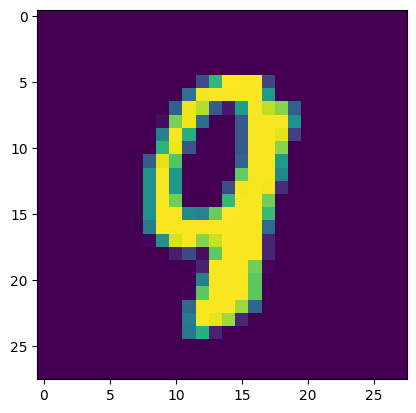

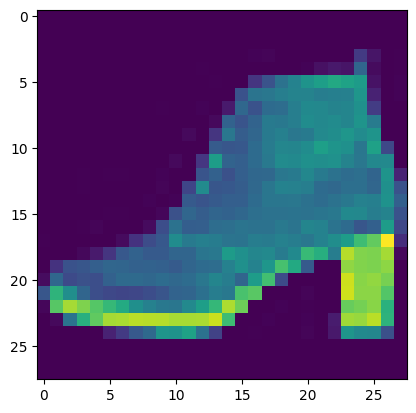

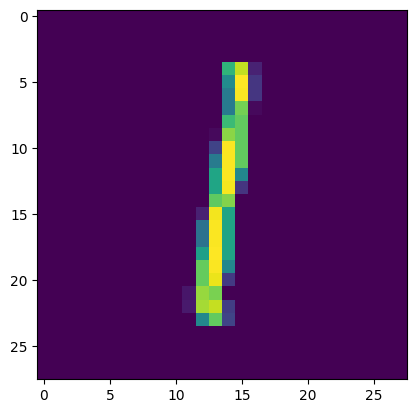

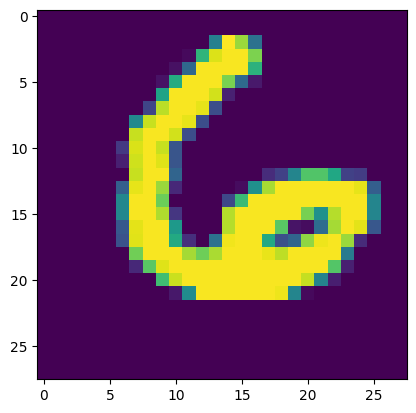

In [8]:
from torch.utils.data import ConcatDataset, DataLoader, RandomSampler
import torchvision
import torch
import matplotlib.pyplot as plt

mnist = torchvision.datasets.MNIST('./data/', download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

fmnist = torchvision.datasets.FashionMNIST('./data/', download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
cifar = torchvision.datasets.CIFAR100('./data/', download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
flowers = torchvision.datasets.Flowers102('./data/', download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

concatenated_dataset = ConcatDataset([mnist, fmnist])

def collate(data):
    """
       data: is a list of tuples with (example, label, length)
             where 'example' is a tensor of arbitrary shape
             and label/length are scalars
    """
    _, labels = zip(*data)
    max_len = 32
    n_ftrs = data[0][0].size(1)
    features = torch.zeros((len(data), max_len, n_ftrs, 1))
    labels = torch.tensor(labels)

    for i in range(len(data)):
        j, k = data[i][0].size(0), data[i][0].size(1)
        features[i] = torch.cat([data[i][0].permute((1,2,0)), torch.zeros((max_len - k, k, 1))])

    return features.float(), labels.long()


train_dataloader = DataLoader(
            concatenated_dataset,
            batch_size=4,
            num_workers=1,
            sampler=RandomSampler(concatenated_dataset),
            persistent_workers=True,
            #collate_fn= collate
        )

for batch in train_dataloader:
    for _ in batch[0]:
        plt.imshow(_.squeeze())
        plt.show()
        
    break

[0, 60000, 120000]


[49337, 108664, 42121, 78364]
[18369, 74173, 58076, 77119]
[27718, 113835, 48404, 103630]


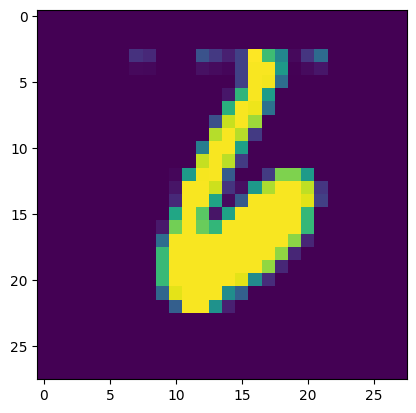

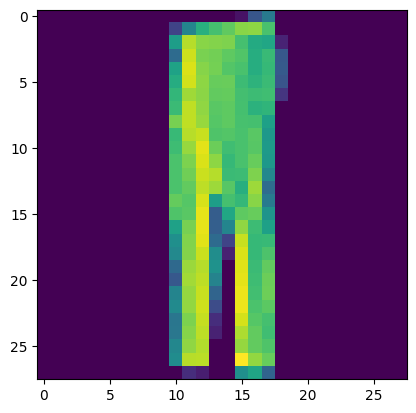

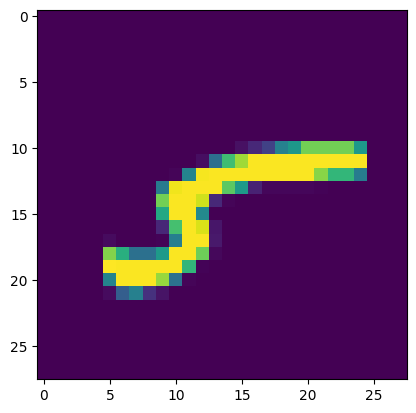

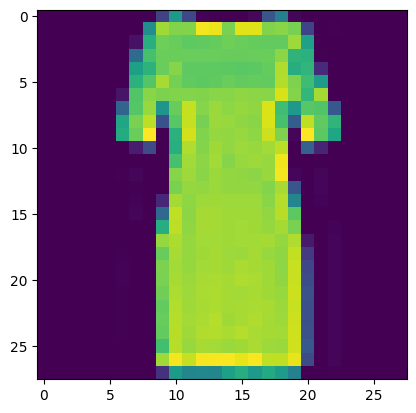

In [44]:
dataloader = DataLoader(
            concatenated_dataset,
            num_workers=1,
            batch_sampler= EqualBatchSampler(concatenated_dataset, 4),
            persistent_workers=True,
            #collate_fn= collate
        )

for batch in dataloader:
    for _ in batch[0]:
        plt.imshow(_.squeeze())
        plt.show()
        
    break